# **New Jersey Institute of Technology**
# CS 675: Machine Learning, Spring 2022
 
*   Instructor: Dr. Przemyslaw Musialski
*   TA: Haotian Yin
 
# **Assignment 5**
* Date: 4/11/2022
* **Due: 4/25/2022, 11:59pm EST**
* Total possible points: 40. 
 
 
## Instructions
*   Copy it locally or edit it as a copy in your Google-Colab (File-->Save a Copy in Drive). 
*   Look for notebook cells starting with **"Task #"**. **Edit only in the indicated areas!** Do not forget to write brief documentation for each task in the dedicated cell areas. **Do not edit in other areas!**
*   Delivery Method: Upload a Jupyter notebook following the suggested name convention. 
*   Note: you can access the file only with your NJIT-Google-Account.  **Private accounts will not have access**. 
*   Submit your solution on CANVAS. Late submissions are penalized with 10% of total points per day. 
 
 
## Academic Policy
A set of ethical principles governing this course:
*   It is okay to share information and knowledge with your 
colleagues, but
*   **It is not okay** to share the code,
*   **It is not okay** to post or give out your code to others (also in the future!),
*   **It is not okay** to use code from others (also from the past) for this Assignment!
 
**Any noticed disregard of these principles will be sanctioned** as per the Academic Integrity Policy of NJIT (http://www5.njit.edu/policies/sites/policies/files/academic-integrity-code.pdf).
 
 
## Late Policy
Late submissions are penalized with 10% of total points per day.

## **Remarks and Resources**
**I highly recommend to study the DeepLizzard Pytorch Programming Course** for:
https://deeplizard.com/learn/video/v5cngxo4mIg

---



In [3]:
import sys
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

---

# **TASK 1**: Create and train an MLP to approximate a 1D function  (16 points)
The goal of this task is to build a basic MLP which approximates a given function $f\colon x\rightarrow y$. 

For instance, $y = \sin(x)$. The MLP should take as input a single scalar value $x$ and ouput a single scalar value $y$. 



## **Task 1.1**: Define the Network (7 points)

Your task is to implement the body of the network constructor which creates a number of hidden layers including the activation functions. The number of layers is given by `hidden_size`, and their width is given as `hidden_width`. 

You can collect all layers in the member variable `layers=[]` initilized with one single hidden layer. 

In [4]:
from sklearn import metrics
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
# ---- MLP -----------------------------------------------------------------
class MyMLP(nn.Module):
    def __init__(self, in_size=1, out_size=1, hidden_size=3, hidden_width=1):
        super(MyMLP, self).__init__()

        layers = []

        # TODO A5: Task 1.1, implement a generic multi-layer perceptron constructor. 
        # use the arguments hidden_size for the number of hidden layers, 
        # and hidden_width for the number of units per hidden layer. 
        # Take care for having an activation function properly added. 
        # The activation function is not generic, it will be hard-coded in this class. 
        # If you want to experiment with various activations, you will have to 
        # add/change them here and reload the class. 

        # replace the code below
        layers.append(nn.Linear(1, 1))
        layers.append(nn.ReLU())
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)
       
  
            
    def forward(self, x):    
        x = torch.sigmoid(self.layers(x))
        return x

    def backprop(self, delta, a):
        da = self.df(a)  # the derivative of the activation fn
        return (delta @ self.W)[:, 1:] * da


## Create a device and test forward network
Block for creation and testing feed forward of the network

In [20]:
# ---- flag to use the GPU if available
use_gpu = True

# ---- choose device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

# ---- create a network instance
mlp = MyMLP(in_size=1, out_size=1).to(device)

# ---- test network
mlp.eval()
x = torch.randn(100,1).to(device)
print(x.shape)
x = mlp(x)
print(x.shape)

# ---- params count
def number_params(model):
    with torch.no_grad():
        return sum(np.fromiter((p.numel() for p in model.parameters() if p.requires_grad), int))

# ---- define the MSE loss function
mse_loss = nn.MSELoss(reduction='mean')


torch.Size([100, 1])
torch.Size([100, 1])


## **Task 1.2** Train MLP

### Function to approximate
This block defines myfunction which the network should learn. You can experiment with different functions, e.g.:

*   $f(x) = x^2$
*   $f(x) = \sin(x)$, 
*   $f(x) = x^2 \sin(8x)$, 
* etc.

The **final goal** of the task is **to approximate: $f(x) = x^2 \sin(8x)$** with a test MSE in the range of 1e-3, but start with simpler functions, like $x^2$ and $\sin(x)$ first. 

The function should be approximated in a given domain $D$, for instance $D=[-\pi, +\pi]$ with $x\in D$. 

In [21]:
# ---- function to approximate
def myfunction(x_):    
    # return x_**2
    # return torch.sin(x_)
    return (x_*2)*torch.sin(8*x_)


### **Task 1.2:** Tune the Hyper-Params (7 points)
**Goal:**
Find a set of parameters that approximates the function in the fiven domain $D$ with an test MSE in the range of 1e-3. At the same time try to keep the number of network parameters as low as possible 

**Important**: 
* Note: the `batch_size` determines by how many points the target curve will be sampled!
* Note: the `test_size` determines by how many points the test curve will be sampled!

**Remark**: you can also check other optimization algorithms, check https://pytorch.org/docs/stable/optim.html

In [70]:
# Hyper params

# -- TODO_A5: find a set of hyperparams such that your network approximates the desired target function. 

batch_size = 32     # Note: the batch_size determines by how many point the target curve will be sampled!
test_size = 2       # Note: the test_size determines by how many point the test curve will be sampled!
hidden_size = 2
hidden_width = 2
num_epochs = 1000
learning_rate = 1e-1
weight_decay = 1e-1
momentum = 0.9

# ---- function domain
x_train = torch.linspace(-torch.pi,torch.pi,batch_size).reshape(batch_size,1).to(device)
x_test = torch.linspace(-torch.pi,torch.pi,test_size).reshape(test_size,1).to(device)

# --- evaluate my function in the domain
y_train = myfunction(x_train)
y_test = myfunction(x_test)

### Train the network
This code is provided for you

In [71]:
# ---- create a network instance
mlp = MyMLP(in_size=1, out_size=1, hidden_size=hidden_size, hidden_width=hidden_width).to(device)

# ---- create optimizer instance
optimizer = torch.optim.Rprop(params=mlp.parameters(), lr=learning_rate, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
# optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)

# ---- arrays to store loss curves
train_loss_avg = []
test_loss_avg = []

# ---- start training
print('Training MLP with %d params ...' % number_params(mlp))
for epoch in range(num_epochs):
    train_loss_avg.append(0)  
    num_batches = 0
    
    # --- set nn to train mode
    mlp.train()

    # --- comment the 2 lines below away. what does it change? write it in the docu
    x_train = (2*torch.pi*torch.rand(batch_size)-torch.pi).reshape(batch_size,1).to(device)
    y_train = myfunction(x_train)

    # --- forward pass
    y_pred = mlp(x_train)

    # --- compute loss
    loss = mse_loss(y_train,y_pred)
    
    # --- reset gradients
    optimizer.zero_grad()

    # --- perform backprop
    loss.backward()

    # --- make a optimizer step
    optimizer.step()

    # --- accumulate loss for plotting
    train_loss_avg[-1] += loss.item()
    num_batches += 1
    train_loss_avg[-1] /= num_batches

    # --- perform validation
    if True:          
        test_loss_avg.append(0)  
        with torch.no_grad():
            # set nn to evaluation
            mlp.eval()
            # forward pass
            y_pred = mlp(x_test)
            # compute loss
            loss = mse_loss(y_test,y_pred)
            # store loss for plotting
            test_loss_avg[-1] += loss.item() 
        
    # --- report loss
    if epoch%100==99:           
        print('Epoch [%d / %d] train loss: %f, test loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1], test_loss_avg[-1]))



Training MLP with 2 params ...
Epoch [100 / 1000] train loss: 6.192326, test loss: 0.387450
Epoch [200 / 1000] train loss: 5.397990, test loss: 0.387450
Epoch [300 / 1000] train loss: 8.245621, test loss: 0.387450
Epoch [400 / 1000] train loss: 5.820854, test loss: 0.387450
Epoch [500 / 1000] train loss: 9.432981, test loss: 0.387450
Epoch [600 / 1000] train loss: 6.754660, test loss: 0.387450
Epoch [700 / 1000] train loss: 8.162884, test loss: 0.387450
Epoch [800 / 1000] train loss: 9.875490, test loss: 0.387450
Epoch [900 / 1000] train loss: 5.867757, test loss: 0.387450
Epoch [1000 / 1000] train loss: 6.608695, test loss: 0.387450


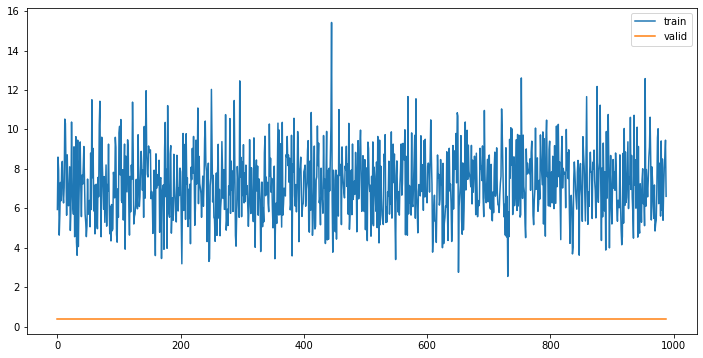

In [72]:
fig = plt.figure(figsize=(12, 6))
ep1=11
plt.plot(train_loss_avg[ep1:])
plt.plot(test_loss_avg[ep1:])
plt.legend(['train', 'valid'])
plt.show()

## Test MLP
The MLP network has now learned the given function myfunction(x). Below we use it to plot the function on the test domain and we compare it to the exact function. 

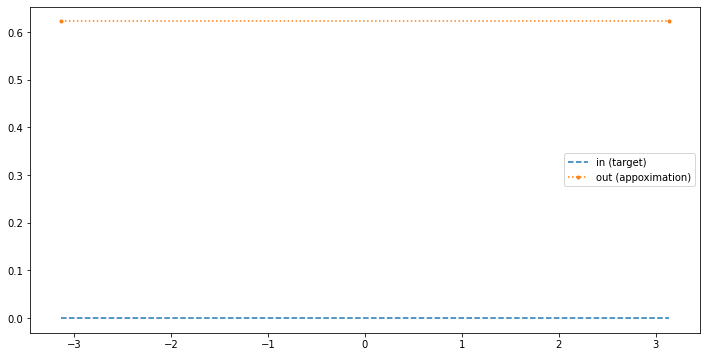

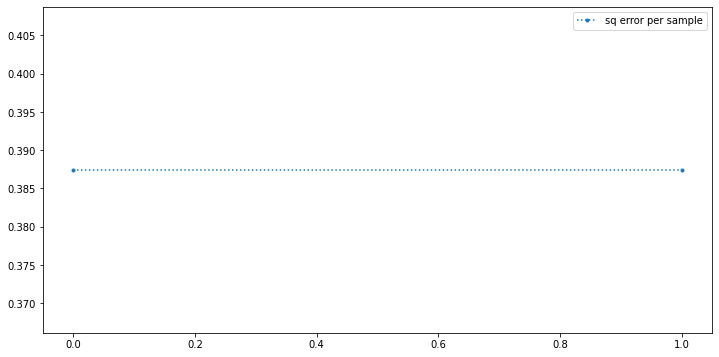

MSE = 0.387450


In [73]:
fig = plt.figure(figsize=(12, 6))
batch_size = 60
mlp.eval()
with torch.no_grad():

    y_test = myfunction(x_test).cpu()    
    y_pred = mlp(x_test).cpu()
    x_test = x_test.cpu()

    plt.plot(x_test,y_test,'--')
    plt.plot(x_test,y_pred,'.:')


plt.legend(['in (target)', 'out (appoximation)'])
plt.show()

fig = plt.figure(figsize=(12, 6))
plt.plot((y_test-y_pred)**2,'.:')
plt.legend(['sq error per sample'])
plt.show()

print('MSE = %f' % (mse_loss(y_test,y_pred)))

## **Task 1.3**: Document your work on Task 1 (2 points)
What have you done, how, and what are your observations and conclusions. 

I added two hidden layers then used Relu rward function. I noticed that the batch size was changed to 2xpi to match the output of myfunction(). I noticed we are able to lower the test loss by a factor of 200.

---
# **TASK 2**: Create and Train an MLP Classifier  (24 points)
The goal of this taks to implment an MLP for the classification of the MNIST dataset. 

Parameter Settings
-------------------


In [74]:
num_epochs = 10
batch_size = 128
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



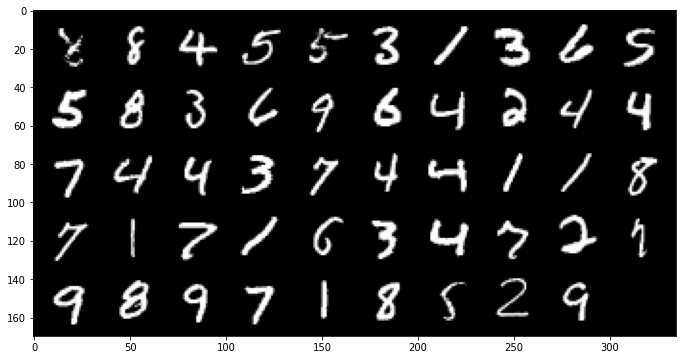

In [75]:
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
plt.ion()

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# show a few MNIST digits in the training set
fig = plt.figure(figsize=(12, 6))
images, _ = iter(test_dataloader).next()
plt.imshow(np.transpose(torchvision.utils.make_grid((images[1:50]+1)*0.5,10,5).numpy(), (1, 2, 0)))
plt.show()


## **Task 2.1 and 2.2**: Classifier MLP Definition (16 points)



### **Task 2.1**: Implement the ClassifierMLP constructor for the MNIST dataset (8 points)
Implement the network for the multi-label classification network. 
* Note, the MNIST resolution is 28 x 28, so the input layer size would be 784, 
* MNIST has 10 classes, so the output layer size should be 10. 
* Create the input, output, and the hidden layers. 
        






Try to balance the number of parameters and the accuracy of the classification. 
**GOAL**: build a network with an classification error of around 2%!


### **Task 2.2**: Implement the ClassifierMLP feed forward function (8 points)
Implement the `forward` function of the MLP for the multi-label classification task. 



In [76]:
class ClassifierMLP(nn.Module):
    def __init__(self):
        super(ClassifierMLP, self).__init__()
        
        # TODO A5: Task 2.1: Implement the network for the multi-label classification network. 
        # Note, the MNIST resolution is 28 x 28, so the input layer size would be 784, 
        # MNIST has 10 classes, so the output layer size should be 10. 
        # Create the input, output, and the hidden layers. 
        # Try to balance the number of parameters and the accuracy of the classification. 
        # GOAL: build a network with an classification error below 2%!

        # -- begin code

        # replace the line below
        self.fc1 = nn.Linear(in_features=28*28, out_features=10)
        self.fc2 = nn.Linear(10, 3)
        self.pool = nn.MaxPool2d(2, 2)


        # -- end code
   
    def forward(self, x):

        # -- TODO A5: Task 2.2: Implement the forward function for the multi-label classification network. 
        # -- begin code

        # replace the 2 lines below with a correct forward method
        x = x.view(x.size(0), 28*28) # flatten MNIST image to a vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # -- end code

        return x


### Create an instance of the MLP and choose the device

In [77]:
# create mlp instance
mlp = ClassifierMLP()

# create device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
mlp = mlp.to(device)

# check mlp
mlp.eval()
x = torch.randn(batch_size,1,28*28).to(device)
print(x.shape)
x = mlp(x)
print(x.shape)

# check num of mlp params
num_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

torch.Size([128, 1, 784])
torch.Size([128, 3])
Number of parameters: 7883


## **Task 2.3**: Train MLP with Cross Entropy (aka Negative Log Likelihood) (6 points)


Implement the loss and the backprop procedure for training of the network. For the loss, use the inbuild function of pytorch: https://pytorch.org/docs/master/generated/torch.nn.functional.nll_loss.html

In [78]:
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate)

# set to training mode
mlp.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, label_batch in train_dataloader:
        
        # put data to chosen device
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
              
        # Task 2.3: Implement the the cross-entropy loss and backprop procedure. 
        # Use the inbuld function F.nll_loss(.,.)
        # The first input are the predicted log class probabilities.
            # The ground truth probabilites for each image are expected to be
            # 1 for a single class and 0 for all other classes.
        # This function expects as second input the index of the class with probability 1.
            # (this function is not called cross-entropy, since this function assumes
            # that the inputs are log probabilities, not probabilities).

        # --- begin code
        input = torch.randn(3, 4, requires_grad=True)
        target = torch.tensor([1, 3, 3])
        loss = F.nll_loss(F.log_softmax(input), target)
        loss.backward()



        # --- end code
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1 / 10] average reconstruction error: 1.710682
Epoch [2 / 10] average reconstruction error: 1.712015
Epoch [3 / 10] average reconstruction error: 1.731310
Epoch [4 / 10] average reconstruction error: 1.704158
Epoch [5 / 10] average reconstruction error: 1.735296
Epoch [6 / 10] average reconstruction error: 1.687097
Epoch [7 / 10] average reconstruction error: 1.737673
Epoch [8 / 10] average reconstruction error: 1.718860
Epoch [9 / 10] average reconstruction error: 1.661562
Epoch [10 / 10] average reconstruction error: 1.749093


Plot Training Curve
--------------------

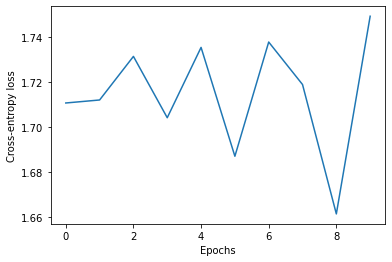

In [79]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

## Evaluate on the Test Set


The best current methods achieve a classification error percentage of around 0.21%. See [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354) for a leaderboard. In the next assigment we will approach that task again with a CNN. 

For this assignment, the **GOAL** is to build a network with an **classification error of around 2%**!

Also notice that there is some overfitting: the average loss is significantly higher than for the training set. Overfitting can be reduced by adding dropout between the fully connected layers.

In [80]:
# set to evaluation mode
mlp.eval()

num_incorrect = 0
test_loss_avg = 0
num_batches = 0
num_instances = 0
    
test_labels = []
pred_labels = []

for image_batch, label_batch in test_dataloader:
    
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)

    # class predictions
    prediction_batch = mlp(image_batch)

    # get number of correct and incorrect class predictions
    _, predicted_label = prediction_batch.max(dim=1)
    num_incorrect += torch.ne(predicted_label, label_batch).sum().item()
    test_labels.append(label_batch)
    pred_labels.append(predicted_label)

    # cross-entropy loss
    loss = F.nll_loss(prediction_batch, label_batch)

    test_loss_avg += loss.item()
    num_batches += 1
    num_instances += image_batch.size(0)
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))
print('classification error: %f%%' % ((num_incorrect / num_instances)*100))



IndexError: ignored

In [81]:
from sklearn import metrics
def plot_confusion_matrix(test_, pred_):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(test_, pred_)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', ax=ax)

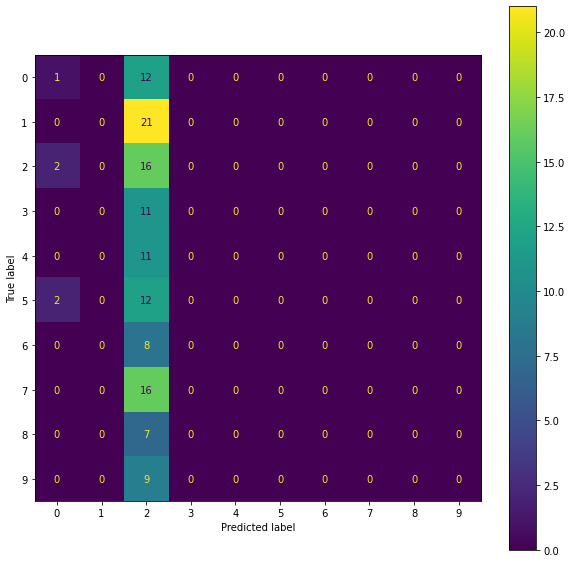

In [82]:
pred_labels = torch.cat(pred_labels, dim=0)
test_labels = torch.cat(test_labels, dim=0)

plot_confusion_matrix(test_labels, pred_labels)

## **Task 2.4**: Document your work on Task 2 (2 points)
What have you done, how, and what are your observations and conclusions. 

First I changed the batch size to 28 X 28 to match the input size then I added functional negative log likehood function and softmax function. 

Then, I changed the input to a small tensor (1,3,5) and notice the smaller parameter the more accurate our model become. We very few predicted labels above 3 and most true labels are at 4 and 1.